In [11]:
import pdb
import pickle
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from nltk.corpus import twitter_samples
from nlp import cosine,get_freq,preprocess_tweet
from os import getcwd

# The word embeddings data for English and French words

Write a program that translates English to French.

In [2]:
en_embeddings_subset = pickle.load(open("en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("fr_embeddings.p", "rb"))

In [10]:
def get_dict(file_name):
    
    file = pd.read_csv(file_name, delimiter=' ')
    dicc = {}
    
    for i in range(len(file)):
        
        en = file.loc[i][0]
        fr = file.loc[i][1]
        dicc[en] = fr

    return dicc

In [12]:
en_fr_train = get_dict('en-fr.train.txt')
en_fr_test = get_dict('en-fr.test.txt')

In [18]:
en_fr_train["the"] , en_fr_train["house"]

('la', 'maison')

![title](https://github.com/ijelliti/Deeplearning.ai-Natural-Language-Processing-Specialization/raw/b737ae959c890506978a8987ccba195a2ee80c4f/1%20-%20Natural%20Language%20Processing%20with%20Classification%20and%20Vector%20Spaces/Labs/Week%204/X_to_Y.jpg)

### Creating matrixes X and Y

In [92]:
def get_matrices(en_fr, french_vecs, english_vecs):

    X_l = list()
    Y_l = list()
    
    english_set = english_vecs.keys()
    french_set = french_vecs.keys()
    french_words = set(en_fr.values())

    for en_word, fr_word in en_fr.items():
        if fr_word in french_set and en_word in english_set:

            en_vec = english_vecs[en_word]
            fr_vec = french_vecs[fr_word]
            X_l.append(en_vec)
            Y_l.append(fr_vec)


    X =  np.vstack(X_l)
    Y = np.vstack(Y_l)


    return X, Y

In [103]:
X_train, Y_train = get_matrices(en_fr_train,fr_embeddings_subset,en_embeddings_subset)

# Translations
Given dictionaries of English and French word embeddings you will create a transformation matrix R

- Given an English word embedding, $\mathbf{e}$, you can multiply $\mathbf{eR}$ to get a new word embedding $\mathbf{f}$.
- Both $\mathbf{e}$ and $\mathbf{f}$ are row vectors.
- You can then compute the nearest neighbors to $\mathbf{f}$ in the french embeddings and recommend the word that is most similar to the transformed word embedding.


                            Find a matrix R that minimizes the following equation. ( with gradient descent)

$\arg \min _{\mathbf{R}}\| \mathbf{X R} - \mathbf{Y}\|_{F}\tag{1} $

$R := R - {\alpha}\frac{d}{dR} \tag{2}$


$\frac{d}{dR} = \frac{2}{m}X^{T}(XR-Y)\tag{3}$

In [94]:
def compute_loss(X, Y, R):
    
    m = X.shape[0]
    loss = (1/m)*np.sum(np.square(np.dot(X,R) - Y))
    
    return loss

In [95]:
def compute_gradient(X, Y, R):
    
    m = X.shape[0]
    gradient = (2/m)*np.dot(X.T,np.dot(X,R) - Y)
    
    return gradient

In [96]:
def gradient_descent(X, Y, train_steps=100, learning_rate=0.0003):
    
    R = np.random.rand(X.shape[1],X.shape[1])
    hist = []
    
    for i in range(train_steps):
        cost = compute_loss(X, Y, R)
        gradient = compute_gradient(X, Y, R)
        R -= learning_rate*gradient
        hist.append(cost)
        
    return R, hist

In [104]:
R_train, hist = gradient_descent(X_train, Y_train, train_steps=400, learning_rate=0.8)

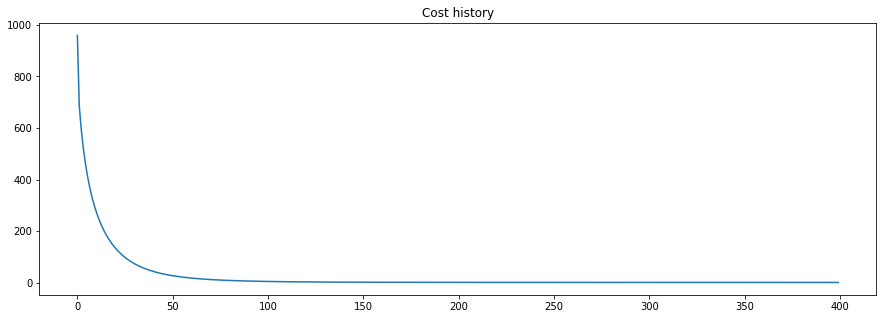

In [105]:
plt.figure(figsize=(15,5))
plt.plot(hist)
plt.title("Cost history")
plt.show()

In [77]:
def nearest_neighbor(v, candidates, k=1):
    
    s = []
    
    for row in candidates:
        s.append(cosine(v, row))
        
    s_idx_sorted = np.argsort(s)
    closest_idx = s_idx_sorted[-k:]
    
    return closest_idx

In [78]:
def test_vocabulary(X, Y, R):
        
    predictions = np.dot(X,R)
    
    correct = 0
    total = len(predictions)
    
    for i in range(len(predictions)):
        pred_idx = nearest_neighbor(predictions[i],Y)
        
        if pred_idx == i:
            correct += 1
    
    accuracy = correct/total
    
    return accuracy

In [106]:
X_val, Y_val = get_matrices(en_fr_test, fr_embeddings_subset, en_embeddings_subset)

In [107]:
test_vocabulary(X_val, Y_val, R_train)

0.5521557719054242

# LSH and document search 
In this part of the assignment, you will implement a more efficient version of k-nearest neighbors using locality sensitive hashing. You will then apply this to document search.

    Process the tweets and represent each tweet as a vector (represent a document with a vector embedding).
    Use locality sensitive hashing and k nearest neighbors to find tweets that are similar to a given tweet.


In [108]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')
all_tweets = all_positive_tweets + all_negative_tweets

In [135]:
def get_document_embedding(tweet, en_embedding):
    tweet = preprocess_tweet(tweet)
    doc_embedding = np.zeros(300)
    for word in tweet:
        doc_embedding += en_embedding.get(word,0)
    return doc_embedding

In [136]:
def get_document_vecs(tweets, en_embeddings):
    
    tweets_dic = {}
    
    matrix_tweets = []
    
    for i, tweet in enumerate(tweets):
        tweet_embedding = get_document_embedding(tweet, en_embeddings)
        tweets_dic[i] = tweet_embedding
        matrix_tweets.append(tweet_embedding)
    
    matrix = np.vstack(matrix_tweets)
    
    return matrix, tweets_dic

In [137]:
document_vecs, ind2Tweet = get_document_vecs(all_tweets, en_embeddings_subset)

Now you have a vector of dimension (m,d) where m is the number of tweets (10,000) and d is the dimension of the embeddings (300). Now you will input a tweet, and use cosine similarity to see which tweet in our corpus is similar to your tweet.

In [148]:
my_tweet = "This doesn't work like I expected"
tweet_embedding = get_document_embedding(my_tweet, en_embeddings_subset)

In [149]:
idx = np.argmax(cosine(document_vecs, tweet_embedding))
print(all_tweets[idx])

@PetiteMistress DO IT! I want to start one for making small games, but I feel like I need to get a jump start before asking for support :(


# Finding the most similar tweets with LSH
You will now implement locality sensitive hashing (LSH) to identify the most similar tweet.

    Instead of looking at all 10,000 vectors, you can just search a subset to find its nearest neighbors.


In [150]:
n_planes = 10
n_universes = 25

$hash =\sum_{i=1}^{n}(2^{i}.h_{i})\tag{1}$

In [152]:
np.random.seed(0)
planes_l = [np.random.normal(size=(300, n_planes)) for _ in range(n_universes)]
# Creates 25 universes with 10 random planes each one.

In [170]:
def hash_value_of_vector(v, planes):
    """Create a hash for a vector; hash_id says which random hash to use.
    Input:
        - v:  vector of tweet. It's dimension is (1, N_DIMS)
        - planes: matrix of dimension (N_DIMS, N_PLANES) - the set of planes that divide up the region
    Output:
        - res: a number which is used as a hash for your vector

    """
    hash_v = 0
    sign = np.sign(np.dot(v,planes))
    bit = (sign >=0)
    bit = np.squeeze(bit)
    
    for i,h in enumerate(bit):
        hash_v += np.power(2,i)*bit[i]
    
    return hash_v

In [172]:
def make_hash_table(vecs, planes):

    num_of_planes = planes.shape[1]
    num_buckets = 2**num_of_planes

    hash_table = {i:[] for i in range(num_buckets)}
    id_table = {i:[] for i in range(num_buckets)}

    for i, v in enumerate(vecs):

        h = hash_value_of_vector(v,planes)
        hash_table[h].append(v)
        id_table[h].append(i)

    return hash_table, id_table

In [175]:
# Creating the hashtables
hash_tables = []
id_tables = []
for universe_id in range(n_universes):  # there are 25 hashes
    print('working on hash universe #:', universe_id)
    planes = planes_l[universe_id]
    hash_table, id_table = make_hash_table(document_vecs, planes)
    hash_tables.append(hash_table)
    id_tables.append(id_table)

working on hash universe #: 0
working on hash universe #: 1
working on hash universe #: 2
working on hash universe #: 3
working on hash universe #: 4
working on hash universe #: 5
working on hash universe #: 6
working on hash universe #: 7
working on hash universe #: 8
working on hash universe #: 9
working on hash universe #: 10
working on hash universe #: 11
working on hash universe #: 12
working on hash universe #: 13
working on hash universe #: 14
working on hash universe #: 15
working on hash universe #: 16
working on hash universe #: 17
working on hash universe #: 18
working on hash universe #: 19
working on hash universe #: 20
working on hash universe #: 21
working on hash universe #: 22
working on hash universe #: 23
working on hash universe #: 24


In [176]:
def approximate_knn(doc_id, v, planes_l, k=1, num_universes_to_use=n_universes):
    
    vecs_to_consider_l = list()
    ids_to_consider_l = list()
    ids_to_consider_set = set()

    for universe_id in range(num_universes_to_use):
        
        planes = planes_l[universe_id]
        hash_value = hash_value_of_vector(v, planes)
        hash_table = hash_tables[universe_id]
        document_vectors_l = hash_table[hash_value]
        id_table = id_tables[universe_id]
        new_ids_to_consider = id_table[hash_value]

        if doc_id in new_ids_to_consider:
            new_ids_to_consider.remove(doc_id)
            print(f"removed doc_id {doc_id} of input vector from new_ids_to_search")

        for i, new_id in enumerate(new_ids_to_consider):
            if new_id not in ids_to_consider_set:
                document_vector_at_i = document_vectors_l[i]
                
                vecs_to_consider_l.append(document_vector_at_i)
                ids_to_consider_l.append(new_id)
                ids_to_consider_set.add(new_id)
                
    print("Fast considering %d vecs" % len(vecs_to_consider_l))
    vecs_to_consider_arr = np.array(vecs_to_consider_l)
    nearest_neighbor_idx_l = nearest_neighbor(v, vecs_to_consider_arr, k=k)
    print(nearest_neighbor_idx_l)
    print(ids_to_consider_l)
    nearest_neighbor_ids = [ids_to_consider_l[idx]
                            for idx in nearest_neighbor_idx_l]

    return nearest_neighbor_ids

In [177]:
doc_id = 0
doc_to_search = all_tweets[doc_id]
vec_to_search = document_vecs[doc_id]

In [180]:
nearest_neighbor_ids = approximate_knn(doc_id, vec_to_search, planes_l, k=3, num_universes_to_use=5)

removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
removed doc_id 0 of input vector from new_ids_to_search
Fast considering 77 vecs
[26  8  0]
[51, 105, 154, 160, 195, 253, 1876, 2478, 701, 1205, 1300, 1581, 1681, 1685, 2714, 4149, 4157, 4232, 4753, 5684, 6821, 9239, 213, 339, 520, 1729, 2140, 2786, 3028, 3162, 3259, 3654, 4002, 4047, 5263, 5492, 5538, 5649, 5656, 5729, 7076, 9063, 9207, 9789, 9927, 207, 254, 1302, 1480, 1815, 2298, 2620, 2741, 3525, 3837, 4704, 4871, 5327, 5386, 5923, 6033, 6371, 6762, 7288, 7472, 7774, 7790, 7947, 8061, 8224, 8276, 8892, 9096, 9153, 9175, 9323, 9740]


In [181]:
print(f"Nearest neighbors for document {doc_id}")
print(f"Document contents: {doc_to_search}")
print("")

for neighbor_id in nearest_neighbor_ids:
    print(f"Nearest neighbor at document id {neighbor_id}")
    print(f"document contents: {all_tweets[neighbor_id]}")

Nearest neighbors for document 0
Document contents: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

Nearest neighbor at document id 2140
document contents: @PopsRamjet come one, every now and then is not so bad :)
Nearest neighbor at document id 701
document contents: With the top cutie of Bohol :) https://t.co/Jh7F6U46UB
Nearest neighbor at document id 51
document contents: #FollowFriday @France_Espana @reglisse_menthe @CCI_inter for being top engaged members in my community this week :)
